In [1]:
import numpy as np
import cv2
import glob
import os
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [2]:
## camera calibration (from openCV docs):
## https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html
## and
## https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0

In [4]:
%%time
CHECKERBOARD = (6,8)

subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW+cv2.CALIB_RATIONAL_MODEL
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('raw_images/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)

CPU times: user 9min 14s, sys: 10.1 s, total: 9min 24s
Wall time: 9min 6s


In [8]:
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

In [9]:
%%time
## calibrate fisheye camera
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6))

CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 2.17 s


In [10]:
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

Found 124 valid images for calibration
DIM=(3072, 2048)
K=np.array([[1511.7515811351739, 0.0, 1496.5712039727027], [0.0, 1497.8201412252656, 1034.2071726674194], [0.0, 0.0, 1.0]])
D=np.array([[-0.0382037494156723], [-0.010632408359621618], [0.01023186781219023], [-0.003464945654065191]])


In [11]:
print(K)

[[1.51175158e+03 0.00000000e+00 1.49657120e+03]
 [0.00000000e+00 1.49782014e+03 1.03420717e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [12]:
## write matrices to file
np.save('B036_intrintics.npy', K)
np.save('B036_distortion.npy', D)

In [13]:
## rectify wide angle distortion
def rectify(image, K, balance=1.0, scale=1.0, dim2=None, dim3=None):
    assert K[2][2] == 1.0
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = (int(dim1[0]*scale), int(dim1[1]*scale))
    
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. 
    # OpenCV document failed to make this clear!
    ## see: https://medium.com/@kennethjiang/calibrate-fisheye-lens-using-opencv-333b05afa0b0
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, dim2, np.eye(3), balance=balance)

    ## scale translation vectors accordingly
    new_K[0][2] *= scale
    new_K[1][2] *= scale
    
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    rectified_img = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return rectified_img

In [14]:
def getSIFTMatchesPair(img1, img2, maskL, maskR):
    """
    detects matching points from a pair of images
    using SIFT feature detection and the Brute force descriptor matcher.
    inputs:
        img1: Grayscale image1
        img2: Grayscale image2
    Returns:
        corners1: numpy array that contains matching corners from image1 in 
                    image coordinates(Nx2)
        corners2: ^likewise for image 2
        descriptors1: feature descriptors (image1) for each matched feature in corners1
        descriptors2: ^ likewise for image 2, corners 2
    """
    ## init sift object
    sift = cv2.SIFT_create()
    corners1, corners2, descriptors1, descriptors2 = [], [], [], []
    
    # find image keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,mask=maskL) ## 'left' image
    kp2, des2 = sift.detectAndCompute(img2,mask=maskR) ## 'right' image
    
    # use BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    for m,n in matches:
        if m.distance < 0.75 * n.distance: ## filter poor matches
            im1_idx = m.queryIdx
            im2_idx = m.trainIdx
            x1, y1 = kp1[im1_idx].pt
            x2, y2 = kp2[im2_idx].pt
            corners1.append((x1, y1))
            corners2.append((x2, y2))
            descriptors1.append(des1[im1_idx])
            descriptors2.append(des2[im2_idx])
        
    corners1 = np.array(corners1, dtype=np.float32)
    corners2 = np.array(corners2, dtype=np.float32)
    descriptors1 = np.array(descriptors1, dtype=np.float32)
    descriptors2 = np.array(descriptors2, dtype=np.float32)
    
    return corners1, corners2, descriptors1, descriptors2

In [34]:
def plotFeatures(img, features):
    feat_x, feat_y = [], []
    for i in range(len(features)):
        feat_x.append(features[i][0])
        feat_y.append(features[i][1])
    fig, ax = plt.subplots(figsize=(12,6))
    ax.imshow(img, cmap='gray')
    ax.scatter(feat_x, feat_y)
    plt.show()
        
def plotFeatureCorr(img1, img2, c1, c2, mask):
    c1_y, c1_x, c2_y, c2_x = [], [], [], []
    assert len(c1) == len(c2)
    for i in range(len(c1)):
        if mask[i] == 1:
            c1_x.append(c1[i][0])
            c1_y.append(c1[i][1])
            c2_x.append(c2[i][0])
            c2_y.append(c2[i][1])
    fig, ax = plt.subplots(1,2, figsize=(20,6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')
    ax[0].scatter(c1_x, c1_y)
    ax[1].scatter(c2_x, c2_y)
    plt.show()

In [16]:
SCALE = 1.1 ## how "far away" to render rectified image

## load images
img_north =  cv2.imread('2_9_2022_test_images/North_2022-02-09_160021_image.jpg')
img_south =  cv2.imread('2_9_2022_test_images/South_2022-02-09_160030_image.jpg')
img_east = cv2.imread('2_9_2022_test_images/East_2022-02-09_160225.jpg')
img_west = cv2.imread('2_9_2022_test_images/West_2022-02-09_160239.jpg')
mask = np.ones([img_west.shape[0], img_west.shape[1], 1], dtype='uint8')


## rectify and convert to grayscale
img_north = cv2.cvtColor(rectify(img_north, K, scale=SCALE), cv2.COLOR_BGR2GRAY)
img_south = cv2.cvtColor(rectify(img_south, K, scale=SCALE), cv2.COLOR_BGR2GRAY)
img_east = cv2.cvtColor(rectify(img_east, K, scale=SCALE), cv2.COLOR_BGR2GRAY)
img_west = cv2.cvtColor(rectify(img_west, K, scale=SCALE), cv2.COLOR_BGR2GRAY)
mask = rectify(mask, K, scale=SCALE)

mask_l = mask.copy()
mask_r = mask.copy()
mask_l[:,:int(mask.shape[1] / 2):] = 0 ## only look for SIFT points on the right half of image
mask_r[:,int(mask.shape[1] / 2):] = 0 ## only look for SIFT points on the left half of image

## West to North

In [37]:
## find keypoints matches in two images (west --> north)
c1, c2, d1, d2 = getSIFTMatchesPair(img_west, img_north, mask_l, mask_r)

## compute a homography between images
H, mask = cv2.findHomography(c1, c2, cv2.RANSAC)

## save H
np.save('H_W_to_N.npy', H)

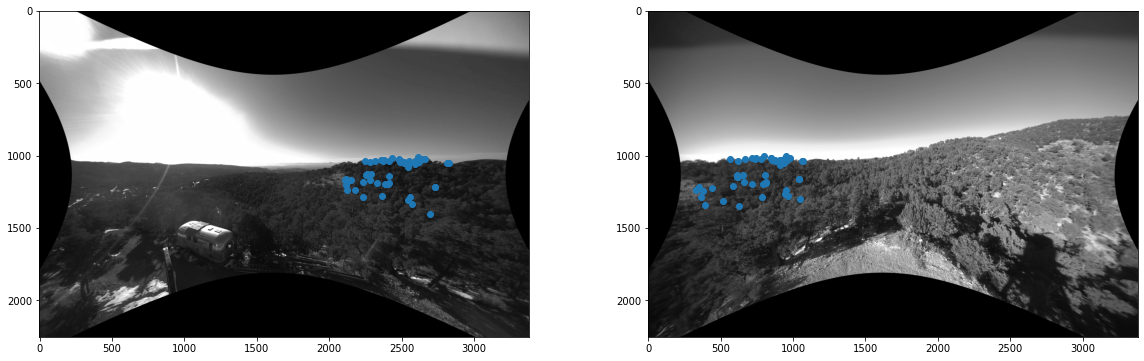

In [38]:
%matplotlib inline
plotFeatureCorr(img_west, img_north, c1, c2, mask)

[[ 928.9912]
 [1025.6228]]


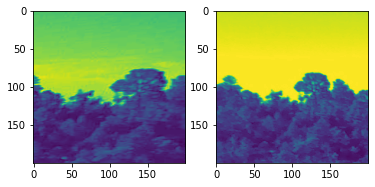

In [39]:
%matplotlib inline

## pick an arbitrary point and check that it maps correctly:
x = 2585
y = 1035

## pt in "right" image (north in this case)
img_pt = H @ np.array([[x],
                       [y],
                       [1]])

## unhomogenize
img_pt = np.array([img_pt[0] / img_pt[-1], img_pt[1] / img_pt[-1]], dtype=np.float32)
print(img_pt)

## draw 200 px windows around the points
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_west[y-100:y+100, x-100:x+100])
ax[1].imshow(img_north[int(img_pt[1]-100):int(img_pt[1]+100), int(img_pt[0]-100):int(img_pt[0]+100)])

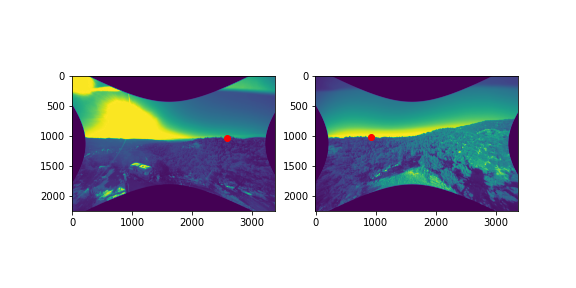

In [40]:
%matplotlib widget

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(x, y, c='red')
ax[1].scatter(int(img_pt[0]), int(img_pt[1]), c='red')
ax[0].imshow(img_west)
ax[1].imshow(img_north)

## North to East

In [41]:
## find keypoints matches in two images (north --> east)
c1, c2, d1, d2 = getSIFTMatchesPair(img_north, img_east, mask_l, mask_r)

## compute a homography between images
H, mask = cv2.findHomography(c1, c2, cv2.RANSAC)

## save H
np.save('H_N_to_E.npy', H)

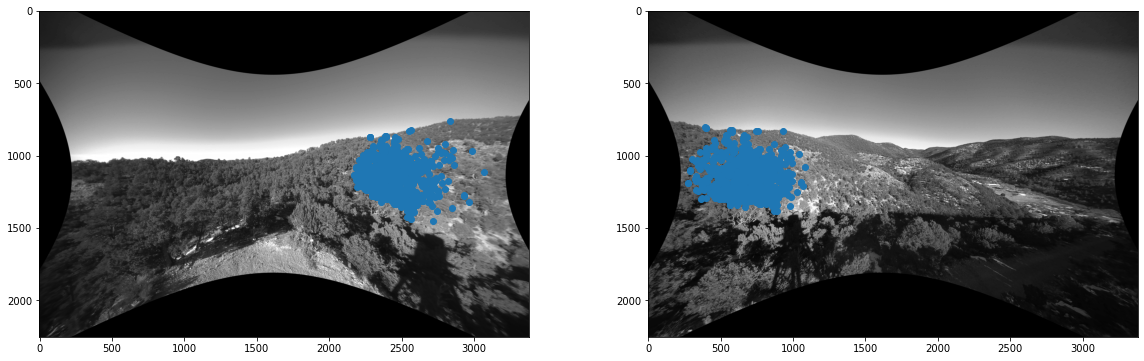

In [42]:
%matplotlib inline
plotFeatureCorr(img_north, img_east, c1, c2, mask)

## East to South

In [46]:
## find keypoints matches in two images (east --> south)
c1, c2, d1, d2 = getSIFTMatchesPair(img_east, img_south, mask_l, mask_r)

## compute a homography between images
H, mask = cv2.findHomography(c1, c2, cv2.RANSAC)

## save H
np.save('H_E_to_S.npy', H)

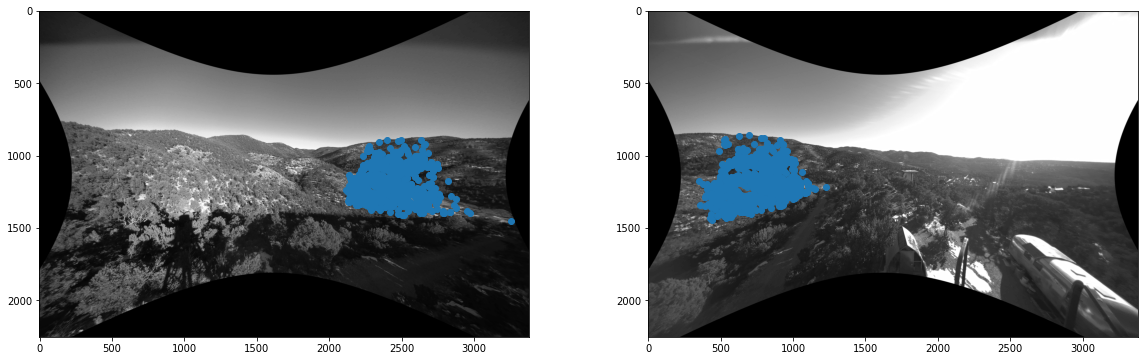

In [47]:
%matplotlib inline
plotFeatureCorr(img_east, img_south, c1, c2, mask)

## South to West

In [48]:
## find keypoints matches in two images (south --> west)
c1, c2, d1, d2 = getSIFTMatchesPair(img_south, img_west, mask_l, mask_r)

## compute a homography between images
H, mask = cv2.findHomography(c1, c2, cv2.RANSAC)

## save H
np.save('H_S_to_W.npy', H)

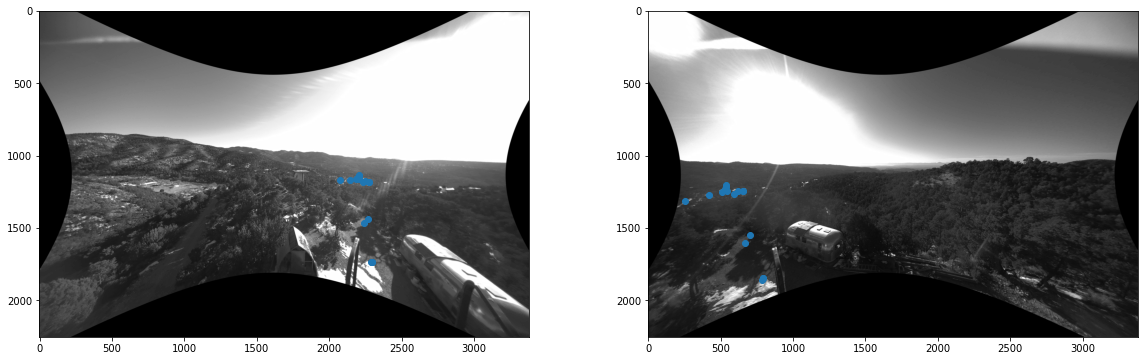

In [49]:
%matplotlib inline
plotFeatureCorr(img_south, img_west, c1, c2, mask)

In [193]:
## time to stitch!